# Importing libraries and loading data

In [161]:
# General and for pre-processing
import numpy as np
import pandas as pd
import pickle
import time
from scipy import misc
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import pywt

# For spliting data and analysing the accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


# For CNN
import keras
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

In [6]:
'''from google.colab import drive
drive.mount('/content/drive')'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

# META
meta = unpickle('./cifar-100-python/meta')
fine_label_names = [t.decode('utf8') for t in meta[b'fine_label_names']]
coarse_label_names = [t.decode('utf8') for t in meta[b'coarse_label_names']]

# TRAIN
train = unpickle('./cifar-100-python/train')
filenames_train = [t.decode('utf8') for t in train[b'filenames']]
fine_labels_train = train[b'fine_labels']
coarse_labels_train = train[b'coarse_labels']
data_train = train[b'data']

# TEST
test = unpickle('./cifar-100-python/test')
filenames_test = [t.decode('utf8') for t in test[b'filenames']]
fine_labels_test = test[b'fine_labels']
coarse_labels_test = test[b'coarse_labels']
data_test = test[b'data']

# Shuffling training data and labels
training_set_for_shuffling = np.column_stack((coarse_labels_train,data_train))
training_set_for_shuffling = np.column_stack((fine_labels_train,training_set_for_shuffling))
np.random.shuffle(training_set_for_shuffling)

# Separating back to data and labels
fine_labels_train = training_set_for_shuffling[:,0]
coarse_labels_train = training_set_for_shuffling[:,1]
data_train = training_set_for_shuffling[:,2:]

coarse_labels_train_array = np.array(coarse_labels_train)
coarse_labels_test_array = np.array(coarse_labels_test)

In [7]:
'''
def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

meta = unpickle('/content/drive/My Drive/COMP5318_Ass2_Group54/cifar-100-python/meta')

fine_label_names = [t.decode('utf8') for t in meta[b'fine_label_names']]
coarse_label_names = [t.decode('utf8') for t in meta[b'coarse_label_names']]

train = unpickle('/content/drive/My Drive/COMP5318_Ass2_Group54/cifar-100-python/train')

filenames_train = [t.decode('utf8') for t in train[b'filenames']]
fine_labels_train = train[b'fine_labels']
coarse_labels_train = train[b'coarse_labels']
data_train = train[b'data']

test = unpickle('/content/drive/My Drive/COMP5318_Ass2_Group54/cifar-100-python/test')

filenames_test = [t.decode('utf8') for t in test[b'filenames']]
fine_labels_test = test[b'fine_labels']
coarse_labels_test = test[b'coarse_labels']
data_test = test[b'data']

# Shuffling training data and labels
training_set_for_shuffling = np.column_stack((coarse_labels_train,data_train))
training_set_for_shuffling = np.column_stack((fine_labels_train,training_set_for_shuffling))
np.random.shuffle(training_set_for_shuffling)

# Separating back to data and labels
fine_labels_train = training_set_for_shuffling[:,0]
coarse_labels_train = training_set_for_shuffling[:,1]
data_train = training_set_for_shuffling[:,2:]

coarse_labels_train_array = np.array(coarse_labels_train)
coarse_labels_test_array = np.array(coarse_labels_test)
'''

In [3]:
def data_to_images(data, change_dtype=False, change_to_array=True):
  '''
  This function convert data in shape (N, 3072)
  into data images with shape (N,32,32,3)
  where N is the number of data
  32 x 32 are the size of image
  3 is the number of channel, RGB
  '''
  images = list()
  for d in data:
    if change_dtype:
      image = np.zeros((32,32,3), dtype=np.uint8)
    else:
      image = np.zeros((32,32,3))
    image[...,0] = np.reshape(d[:1024], (32,32)) # Red channel
    image[...,1] = np.reshape(d[1024:2048], (32,32)) # Green channel
    image[...,2] = np.reshape(d[2048:], (32,32)) # Blue channel
    images.append(image)

  if change_to_array:
    images = np.array(images)

  return images

In [4]:
images_train = data_to_images(data_train, change_dtype= True)
images_test = data_to_images(data_test, change_dtype= True)

In [5]:
def show(images,i):  
  '''
  This function is to plot the image with its coarse and fine labels.
  Input 1: list or array of reshaped images e.g. shape (N,32,32,3)
  Input 2: index of the image wish to show
  '''
  image = images[i]
  
  if image.min() < 0:
    image = np.clip(image, 0, 1)

  plt.imshow(image)
  plt.title("Superclass " + str(coarse_labels_train[i]) + ": " + coarse_label_names[coarse_labels_train[i]]+ "\n" \
            "Class " + str(fine_labels_train[i]) + ": " + fine_label_names[fine_labels_train[i]] )
  plt.show()
  plt.close()

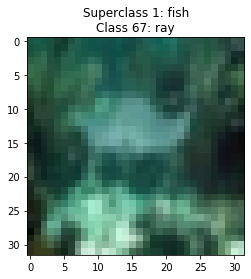

In [6]:
show(images_train,1)

# Preprocessing functions

## Standardising

In [7]:
def standardise(data_train, data_test):
  '''
  This function is used for standardising the data

  Shape of input data: (N,3072)
  Shape of output data: (N,3072)
  '''

  # Get the mean and std dev of training set along its row
  mean = data_train.mean(axis=0)
  stdv = data_train.std(axis=0)

  # Subtract each pixel with the mean
  data_train_standard = (data_train - mean)/stdv
  data_test_standard = (data_test - mean)/stdv


  return data_train_standard, data_test_standard



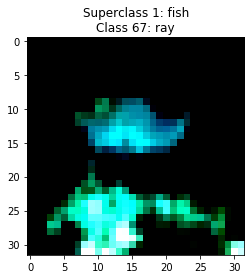

In [8]:
train_STD, test_STD = standardise(data_train, data_test)
images_STD = data_to_images(train_STD)
show(images_STD,1)

## Wavelet transform (in multichannel)

In [9]:
def _wavelet(image,wavelet,wavelet_levels,retain_percent):
  '''
  This helper function is the process of wavelet transforming
  Input1: a channel of a multichannel image OR a grayscaled image
  Input2: type of wavelet
  Input3: wavelet level
  Input4: feature retaining percentage
  Output: a wavelet-transformed channel OR grayscaled image
  '''
  coeffs = pywt.wavedec2(image,wavelet= wavelet, level= wavelet_levels)
  coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
  Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
  thresh_w = Csort[int(np.floor((1-retain_percent)*len(Csort)))]
  ind_w = np.abs(coeff_arr) > thresh_w
  Cfilt = coeff_arr * ind_w
  coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format="wavedec2")
  recon_image = pywt.waverec2(coeffs_filt, wavelet= wavelet)
  return recon_image

def wavelet_transform(image,wavelet,level,retain_percent):
  '''
  This function is to apply wavelet transform to each channel of the image data
  Input1: an image with shape (32,32,3)
  Input2: type of wavelet
  Input3: wavelet level
  Input4: feature retaining percentage
  Output: a wavelet-transformed image with shape (32,32,3)
  '''
  output = np.empty_like(image)
  for c in range(image.shape[-1]):
    output[..., c] = _wavelet(image[..., c], wavelet, level, retain_percent)
  return output

def preprocess_wavelet(images_data,retain_percent,wavelet="db1",level=4):
  '''
  This function is to apply wavelet transform to images data

  Input1: images data in shape (N,32,32,3)
  Input2: feature retaining percentage in decimals (50% = 0.5)
  Input3: wavelet_level (optional,by default 4)
  Input4: type of wavelet (optional,by default Daubechies1)

  Output: wavelet-transformed images data in shape (N,32,32,3)
  '''
  X_data_wavelet = []

  for i in images_data:
    w_compressed = wavelet_transform(i,wavelet,level,retain_percent)
    X_data_wavelet.append(w_compressed)

  #Change the list into an array
  X_data_wavelet = np.array(X_data_wavelet)

  return X_data_wavelet

## ZCA whitening

In [10]:
def zca(data_train, data_test, epsilon = 0.1, Norm=True,Centre=True):
  '''
  This function takes in the data_train and data_test variables as they were originally defined
  and returns train and test Zero Component Analysis whitened matrices of the same shape as our
  inputs.
  '''

  # Normalise
    
  if Norm == True:
      data_train = data_train/255
      data_test = data_test/255
  
  # Centre (for the covariance matrix)
  
  if Centre == True:
      mean = data_train.mean(axis=0)
      data_train = data_train - mean
      data_test = data_test - mean
  
  # Covariance Matrix
  
  covariance_matrix = np.cov(data_train, rowvar=False)
  covariance_matrix_test = np.cov(data_test, rowvar=False)
  
  # SVD of Covariance Matrix
  
  U,S,V = np.linalg.svd(covariance_matrix)
  Utest,Stest,Vtest = np.linalg.svd(covariance_matrix_test)
  

  # ZCA Transform
  
  # Epsilon is a hyper parameter we can tune, epsilon is 0.1 by default
  
  data_train_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(data_train.T).T

  data_test_ZCA = Utest.dot(np.diag(1.0/np.sqrt(Stest + epsilon))).dot(Utest.T).dot(data_test.T).T

  # Normalise the ZCA result into the range 0 and 1
  
  if Norm == True:
      data_train_ZCA = (data_train_ZCA - data_train_ZCA.min()) / (data_train_ZCA.max() - data_train_ZCA.min())
  
      data_test_ZCA = (data_test_ZCA - data_test_ZCA.min()) / (data_test_ZCA.max() - data_test_ZCA.min())
  
  
  return data_train_ZCA, data_test_ZCA

# Run the pre-processing and split the data

In [11]:
# Standardisation of data
data_train_standard, data_test_standard = standardise(data_train,data_test)
data_train_standard = data_to_images(data_train_standard)
data_test_standard = data_to_images(data_test_standard)

# Wavelet transform of data
data_train_wavelet = preprocess_wavelet(data_train_standard,0.5)
data_test_wavelet = preprocess_wavelet(data_test_standard, 0.5)

# ZCA transform of data
data_train_ZCA, data_test_ZCA = zca(data_train, data_test)
data_train_ZCA = data_to_images(data_train_ZCA)
data_test_ZCA = data_to_images(data_test_ZCA)

# Split datasets into Train, Validate, and Test sets
x_train_std = data_train_standard[:33000]
x_test_std = data_test_standard
x_val_std = data_train_standard[33000:]

x_train_wavelet = data_train_wavelet[:33000]
x_test_wavelet = data_test_wavelet
x_val_wavelet = data_train_wavelet[33000:]

x_train_zca = data_to_images(data_train_ZCA[:33000])
x_test_zca = data_to_images(data_test_ZCA)
x_val_zca = data_to_images(data_train_ZCA[33000:])

# Splitting the labels and encoding as 'one-hot vector'
y_train_cnn = coarse_labels_train[:33000]
y_test_cnn = coarse_labels_test
y_val_cnn = coarse_labels_train[33000:]
num_classes = 20
y_train_cnn = keras.utils.to_categorical(y_train_cnn, num_classes)
y_test_cnn = keras.utils.to_categorical(y_test_cnn, num_classes)
y_val_cnn = keras.utils. to_categorical(y_val_cnn, num_classes)

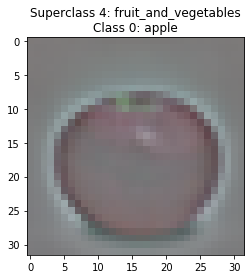

In [12]:
show(x_train_zca, 76)

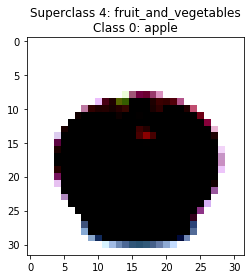

In [13]:
show(x_train_std, 76)

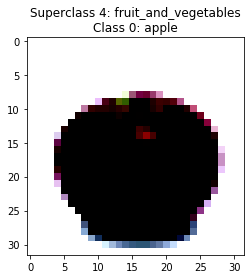

In [14]:
show(x_train_wavelet,76)

# Class for Convolutional Neural Network archtitecture 

In [137]:
class Conv_Neural_Net:

  def __init__(self, num_classes=20, learn_r=0.001, epochs=30, batch_size=32, Verbose=0, optimiZer='RMSprop'):
    self.classifier = Sequential()
    self.number_of_classes = num_classes
    self.learning_rate = learn_r
    self.Epochs = epochs
    self.Batch_Size = batch_size
    self.verbose = Verbose
    self.opt = optimiZer

    # Convolutional Layer 1
    self.classifier.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same',input_shape=x_train_cnn.shape[1:]))
    self.classifier.add(Activation('relu'))
    self.classifier.add(BatchNormalization())
    self.classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    self.classifier.add(Conv2D(32, (3,3), strides=(1,1),padding='same'))
    self.classifier.add(Activation('relu'))
    self.classifier.add(BatchNormalization())
    self.classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    self.classifier.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
    self.classifier.add(Activation('relu'))
    self.classifier.add(BatchNormalization())
    self.classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 4
    self.classifier.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
    self.classifier.add(Activation('relu'))
    self.classifier.add(BatchNormalization())
    self.classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten
    self.classifier.add(Flatten())

    # Dense Layer 1
    self.classifier.add(Dense(512))
    self.classifier.add(Activation('relu'))
    self.classifier.add(Dropout(0.4))
    self.classifier.add(BatchNormalization())
    
    # Output Layer
    self.classifier.add(Dense(self.number_of_classes))
    self.classifier.add(Activation('relu'))
    self.classifier.add(Dropout(0.4))
    self.classifier.add(BatchNormalization())
    # Softmax Activation 
    self.classifier.add(Activation('softmax'))

    # RMSprop optimizer
    if self.opt == 'RMSprop':
        OPT = keras.optimizers.RMSprop(lr=self.learning_rate, decay=1e-6)
    elif self.opt == 'Adam':
        OPT = keras.optimizers.Adam(lr=self.learning_rate)

    # Compile our classifier
    self.classifier.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

  def fit_conv_neural_net(self, train_data, train_labels, val_data, val_labels):
    return self.classifier.fit(train_data, train_labels, batch_size=self.Batch_Size, epochs=self.Epochs,
              validation_data=(val_data, val_labels), shuffle=True, verbose=self.verbose)
  
  def predict(self,test_data):
    probabilities = self.classifier.predict(test_data)
    predictions = probabilities.argmax(axis=1)
    return predictions
    
  def return_accuracy(self,test_data, test_labels):
    accuracy = self.classifier.evaluate(test_data, test_labels, batch_size=32, verbose=1)
    print("\nTest accuracy is {}%".format(100.0*accuracy[1]))
    return accuracy

  def classifier_summary(self):
    return self.classifier.summary(line_length=None, positions=None, print_fn=None)

# Example Code

In [169]:
'''
### Example code ###
start_time = time.time()

x_train_cnn = x_train_zca.astype('float32')
y_train_cnn = y_train_cnn

x_val_cnn = x_val_zca.astype('float32')
y_val_cnn = y_val_cnn

x_test_cnn = x_test_zca.astype('float32')
y_test_cnn = y_test_cnn

CNN = Conv_Neural_Net(learn_r=0.001,epochs=1,num_classes=20, batch_size=32, Verbose=0, optimiZer='Adam')

CNN.fit_conv_neural_net(x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn)

CNN.return_accuracy(x_test_cnn, y_test_cnn)

y_pred = CNN.predict(x_test_cnn)

end_time = time.time() - start_time
print(end_time)
'''

"\n### Example code ###\nstart_time = time.time()\n\nx_train_cnn = x_train_zca.astype('float32')\ny_train_cnn = y_train_cnn\n\nx_val_cnn = x_val_zca.astype('float32')\ny_val_cnn = y_val_cnn\n\nx_test_cnn = x_test_zca.astype('float32')\ny_test_cnn = y_test_cnn\n\nCNN = Conv_Neural_Net(learn_r=0.001,epochs=1,num_classes=20, batch_size=32, Verbose=0, optimiZer='Adam')\n\nCNN.fit_conv_neural_net(x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn)\n\nCNN.return_accuracy(x_test_cnn, y_test_cnn)\n\ny_pred = CNN.predict(x_test_cnn)\n\nend_time = time.time() - start_time\nprint(end_time)\n"

In [71]:
#CNN.classifier_summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_44 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 16, 16, 32)       

# Experimental Setting

In [120]:
def accuracy(predictions, label_test):
    return accuracy_score(label_test,predictions)

def recall(predictions, label_test):
    return recall_score(label_test,predictions,average='macro')  

def precision(predictions, label_test):  
    return precision_score(label_test,predictions,average='macro') 

def CONFUSION_matrix(predictions, label_test):
    return confusion_matrix(label_test,predictions)

### Standardised Dataset

In [93]:
'''start_time_CNN_std = time.time()
kf = KFold(n_splits=10)

test_set = data_test_standard
test_labels = coarse_labels_test_array

cv_accuracy_list_std = []
cv_recall_list_std = []
cv_precision_list_std = []

i = 1
for tr_i, ts_i in kf.split(data_train_standard):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_tr, X_ts = data_train_standard[tr_i], data_train_standard[ts_i]
    y_tr, y_ts = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    y_tr_OHV = keras.utils.to_categorical(y_tr, 20) # One-Hot-Vector Encoding
    y_ts_OHV = keras.utils.to_categorical(y_ts, 20) # One-Hot-Vector Encoding
    
    # 1. Create a CNN classifier
    CNN_std = Conv_Neural_Net(learn_r=0.001,epochs=5,num_classes=20, batch_size=32, Verbose=0)

    # 2. Training the model using the splits from the Kfold step
    CNN_std.fit_conv_neural_net(X_tr, y_tr_OHV, X_ts, y_ts_OHV)

    #Predict the response for test dataset
    y_pred = CNN_std.predict(test_set)
    cv_accuracy_list_std.append(accuracy(y_pred,test_labels))
    cv_recall_list_std.append(recall(y_pred,test_labels))
    cv_precision_list_std.append(precision(y_pred,test_labels))
    i += 1
    del CNN_std, X_tr, X_ts, y_tr, y_ts, y_pred, y_tr_OHV, y_ts_OHV

time_CNN_std = time.time() - start_time_CNN_std'''

Step:  1 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  2 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  3 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  4 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  5 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  6 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  7 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  8 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  9 TRAIN:  (45000,)  | TEST:  (5000,)
Step:  10 TRAIN:  (45000,)  | TEST:  (5000,)


In [94]:
# The above print out is a typo. It should have the following structure.
print('Step: i TRAIN: (50000,) | TEST: (10000,)')

# This is because for CNN, we use the 10-fold train:val splits to train the network,
# and then we use the test set to report the results.

Step: i TRAIN: (50000,) | TEST: (10000,)


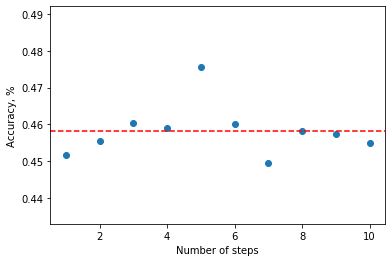

In [95]:
'''plt.scatter(range(1, 11), cv_accuracy_list_std)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_accuracy_list_std))'''

In [96]:
'''time_CNN_std'''

4614.447829961777

In [111]:
'''print('Recall: ',np.average(cv_recall_list_std))
print('Accuracy: ',np.average(cv_accuracy_list_std))
print('Precision',np.average(cv_precision_list_std))'''

Recall:  0.4582
Accuracy:  0.4582
Precision 0.4582


### Wavelet Transformed Dataset

In [97]:
'''start_time_CNN_wav = time.time()
kf = KFold(n_splits=10)

test_set = data_test_wavelet
test_labels = coarse_labels_test_array

cv_accuracy_list_wav = []
cv_recall_list_wav = []
cv_precision_list_wav = []

i = 1
for tr_i, ts_i in kf.split(data_train_wavelet):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", data_train_wavelet.shape, " | TEST: ", test_set.shape)
    X_tr, X_ts = data_train_wavelet[tr_i], data_train_wavelet[ts_i]
    y_tr, y_ts = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    y_tr_OHV = keras.utils.to_categorical(y_tr, 20) # One-Hot-Vector Encoding
    y_ts_OHV = keras.utils.to_categorical(y_ts, 20) # One-Hot-Vector Encoding
    
    # 1. Create a CNN classifier
    CNN_wav = Conv_Neural_Net(learn_r=0.001,epochs=5,num_classes=20, batch_size=32, Verbose=0)

    # 2. Training the model using the splits from the Kfold step
    CNN_wav.fit_conv_neural_net(X_tr, y_tr_OHV, X_ts, y_ts_OHV)

    #Predict the response for test dataset
    y_pred = CNN_wav.predict(test_set)
    cv_accuracy_list_wav.append(accuracy(y_pred,test_labels))
    cv_recall_list_wav.append(recall(y_pred,test_labels))
    cv_precision_list_wav.append(precision(y_pred,test_labels))
    i += 1
    del CNN_wav, X_tr, X_ts, y_tr, y_ts, y_pred, y_tr_OHV, y_ts_OHV

time_CNN_wav = time.time() - start_time_CNN_wav'''

Step:  1 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  2 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  3 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  4 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  5 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  6 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  7 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  8 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  9 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  10 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)


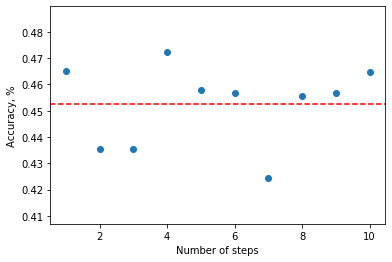

In [98]:
'''plt.scatter(range(1, 11), cv_accuracy_list_wav)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_accuracy_list_wav))'''

In [99]:
'''time_CNN_wav'''

4521.741277933121

In [110]:
'''print('Recall: ',np.average(cv_recall_list_wav))
print('Accuracy: ',np.average(cv_accuracy_list_wav))
print('Precision',np.average(cv_precision_list_wav))'''

Recall:  0.45248
Accuracy:  0.45248
Precision 0.45248


### ZCA Transformed Dataset

In [102]:
'''start_time_CNN_zca = time.time()
kf = KFold(n_splits=10)

test_set = data_test_ZCA
test_labels = coarse_labels_test_array

cv_accuracy_list_zca = []
cv_recall_list_zca = []
cv_precision_list_zca = []

i = 1
for tr_i, ts_i in kf.split(data_train_ZCA):
    
    # 1. Getting through the Kfold configuration
    print("Step: ", i, "TRAIN: ", data_train_ZCA.shape, " | TEST: ", test_set.shape)
    X_tr, X_ts = data_train_ZCA[tr_i], data_train_ZCA[ts_i]
    y_tr, y_ts = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    y_tr_OHV = keras.utils.to_categorical(y_tr, 20) # One-Hot-Vector Encoding
    y_ts_OHV = keras.utils.to_categorical(y_ts, 20) # One-Hot-Vector Encoding
    
    # 1. Create a CNN classifier
    CNN_zca = Conv_Neural_Net(learn_r=0.001,epochs=5,num_classes=20, batch_size=32, Verbose=0)

    # 2. Training the model using the splits from the Kfold step
    CNN_zca.fit_conv_neural_net(X_tr, y_tr_OHV, X_ts, y_ts_OHV)

    #Predict the response for test dataset
    y_pred = CNN_zca.predict(test_set)
    cv_accuracy_list_zca.append(accuracy(y_pred,test_labels))
    cv_recall_list_zca.append(recall(y_pred,test_labels))
    cv_precision_list_zca.append(precision(y_pred,test_labels))
    i += 1
    del CNN_zca, X_tr, X_ts, y_tr, y_ts, y_pred, y_tr_OHV, y_ts_OHV

time_CNN_zca = time.time() - start_time_CNN_zca'''

Step:  1 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  2 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  3 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  4 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  5 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  6 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  7 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  8 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  9 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)
Step:  10 TRAIN:  (50000, 32, 32, 3)  | TEST:  (10000, 32, 32, 3)


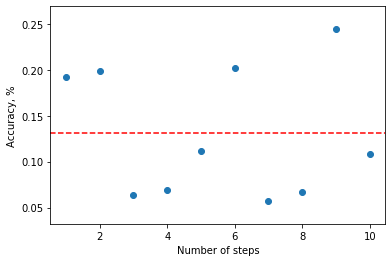

In [103]:
'''plt.scatter(range(1, 11), cv_accuracy_list_zca)
plt.xlabel("Number of steps")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='red', y=np.average(cv_accuracy_list_zca))'''

In [104]:
'''time_CNN_zca'''

5033.056449890137

In [109]:
'''print('Recall: ',np.average(cv_recall_list_zca))
print('Accuracy: ',np.average(cv_accuracy_list_zca))
print('Precision',np.average(cv_precision_list_zca))'''

Recall:  0.13147999999999999
Accuracy:  0.13147999999999999
Precision 0.13147999999999999


# Tuning Learning Rate for gradient descent

In [116]:
'''learning_rates = [0.5, 0.1, 0.01, 0.005, 0.002, 0.001, 0.0008, 0.0005, 0.0001, 0.00001]


start_time_CNN_LR = time.time()
kf = KFold(n_splits=10)

test_set = data_test_standard
test_labels = coarse_labels_test_array

LR_accuracy_list_std = []
LR_recall_list_std = []
LR_precision_list_std = []

i = 0
for tr_i, ts_i in kf.split(data_train_standard):
    LR = learning_rates[i]
    # 1. Getting through the Kfold configuration
    #print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_tr, X_ts = data_train_standard[tr_i], data_train_standard[ts_i]
    y_tr, y_ts = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    y_tr_OHV = keras.utils.to_categorical(y_tr, 20) # One-Hot-Vector Encoding
    y_ts_OHV = keras.utils.to_categorical(y_ts, 20) # One-Hot-Vector Encoding
    
    # 1. Create a CNN classifier
    CNN_LR = Conv_Neural_Net(learn_r=LR,epochs=5,num_classes=20, batch_size=32, Verbose=0)

    # 2. Training the model using the splits from the Kfold step
    CNN_LR.fit_conv_neural_net(X_tr, y_tr_OHV, X_ts, y_ts_OHV)

    #Predict the response for test dataset
    y_pred = CNN_LR.predict(test_set)
    LR_accuracy_list_std.append(accuracy(y_pred,test_labels))
    LR_recall_list_std.append(recall(y_pred,test_labels))
    LR_precision_list_std.append(precision(y_pred,test_labels))
    i += 1
    del CNN_LR, X_tr, X_ts, y_tr, y_ts, y_pred, y_tr_OHV, y_ts_OHV

time_CNN_LR = time.time() - start_time_CNN_LR'''

In [146]:
'''time_CNN_LR'''

4813.428246974945

Text(0, 0.5, 'Accuracy, %')

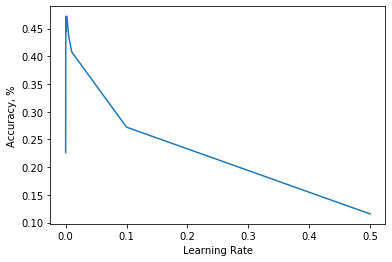

In [117]:
'''plt.plot(learning_rates, LR_accuracy_list_std)
plt.xlabel("Learning Rate")
plt.ylabel('Accuracy, %')'''

In [170]:
'''print(LR_accuracy_list_std)
print(learning_rates)'''

[0.1155, 0.2721, 0.4078, 0.4356, 0.4722, 0.4516, 0.4448, 0.4723, 0.4042, 0.2264]
[0.5, 0.1, 0.01, 0.005, 0.002, 0.001, 0.0008, 0.0005, 0.0001, 1e-05]


In [128]:
'''lr_subset = learning_rates[2:9]
lr_accur_subset = LR_accuracy_list_std[2:9]'''

### Zooming in on 0.01 - 0.0001 on our learning rate plot

Text(0, 0.5, 'Accuracy, %')

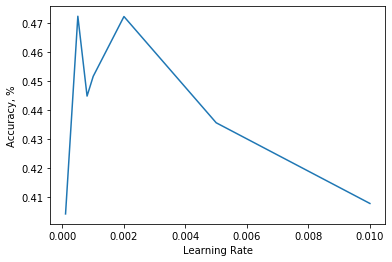

In [133]:
'''plt.plot(lr_subset, lr_accur_subset)
plt.xlabel("Learning Rate")
plt.ylabel('Accuracy, %')'''

# Tuning for best optimizer for gradient descent

In [143]:
'''start_time_CNN_opt = time.time()
kf = KFold(n_splits=10)

test_set = data_test_standard
test_labels = coarse_labels_test_array

opt_accuracy_list_std = []
opt_recall_list_std = []
opt_precision_list_std = []

i = 0
for tr_i, ts_i in kf.split(data_train_standard):
    
    if i < 5:
        optim = 'RMSprop'
    else:
        optim = 'Adam'

    # 1. Getting through the Kfold configuration
    #print("Step: ", i, "TRAIN: ", tr_i.shape, " | TEST: ", ts_i.shape)
    X_tr, X_ts = data_train_standard[tr_i], data_train_standard[ts_i]
    y_tr, y_ts = coarse_labels_train_array[tr_i], coarse_labels_train_array[ts_i]
    
    y_tr_OHV = keras.utils.to_categorical(y_tr, 20) # One-Hot-Vector Encoding
    y_ts_OHV = keras.utils.to_categorical(y_ts, 20) # One-Hot-Vector Encoding
    
    # 1. Create a CNN classifier
    CNN_opt = Conv_Neural_Net(learn_r=LR,epochs=5,num_classes=20, batch_size=32, Verbose=0, optimiZer=optim)

    # 2. Training the model using the splits from the Kfold step
    CNN_opt.fit_conv_neural_net(X_tr, y_tr_OHV, X_ts, y_ts_OHV)

    #Predict the response for test dataset
    y_pred = CNN_opt.predict(test_set)
    opt_accuracy_list_std.append(accuracy(y_pred,test_labels))
    opt_recall_list_std.append(recall(y_pred,test_labels))
    opt_precision_list_std.append(precision(y_pred,test_labels))
    i += 1
    del CNN_opt, X_tr, X_ts, y_tr, y_ts, y_pred, y_tr_OHV, y_ts_OHV

time_CNN_opt = time.time() - start_time_CNN_opt'''

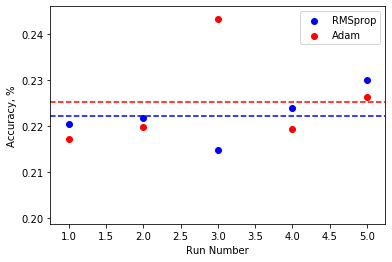

In [148]:
'''run_number = [1,2,3,4,5]
RMSprops = opt_accuracy_list_std[0:5]
Adams = opt_accuracy_list_std[5:]
plt.scatter(run_number, RMSprops, color='blue', label='RMSprop')
plt.scatter(run_number, Adams, color='red', label='Adam')
plt.xlabel("Run Number")
plt.ylabel('Accuracy, %')
plt.axhline(linestyle='--', color='blue', y=np.average(RMSprops))
plt.axhline(linestyle='--', color='red', y=np.average(Adams))
plt.legend()'''

In [149]:
'''time_CNN_opt'''

6233.617739915848

Given that the results are very close for our two optimizer choices, RMSprop and Adam, we will choose RMSprop as it seemed to generally perform better than Adam, and if we take run number 3 to be an outlier for each, then RMSprop would also have the highest average performance.

# Tuned / Best Model - CNN

Accuracy of CNN is 0.4843 \
Recall of CNN is 0.4843 \
Precision of CNN is 0.4832 \
The time to run this algorithm is 13.994 minutes

We run our final model with an increased number of epochs (10 epochs) compared to our k-folds validation and parameter tuning (Only 5 epochs). This is because running more epochs seemed to be a computationally costly decision and so to be able to tune parameters and have our algorithm run in feasible times we chose to only run 5 epochs. Our final reporting of accuracy, precision, recall, and confusion matrix on the test set is reported after our algorithm ran for 10 epochs on our best tuned model. 

In [151]:
start_time = time.time()

FINAL_train = data_train_standard[:33000]
FINAL_valid = data_train_standard[33000:]
FINAL_test = data_test_standard

FINAL_train_labels = coarse_labels_train_array[:33000]
FINAL_valid_labels = coarse_labels_train_array[33000:]
FINAL_test_labels = coarse_labels_test_array

OHV_train_labels = keras.utils.to_categorical(FINAL_train_labels, 20) # One-Hot-Vector Encoding
OHV_valid_labels = keras.utils.to_categorical(FINAL_valid_labels, 20) # One-Hot-Vector Encoding

# Create Classifier
CNN_FINAL = Conv_Neural_Net(learn_r=0.002,epochs=10,num_classes=20, batch_size=32, Verbose=1, optimiZer='RMSprop')

# Train Classifier
CNN_FINAL.fit_conv_neural_net(FINAL_train, OHV_train_labels, FINAL_valid, OHV_valid_labels)

# Predict on test set
y_pred = CNN_FINAL.predict(FINAL_test)

BEST_MODEL_TIME = time.time() - start_time

Train on 33000 samples, validate on 17000 samples
Epoch 1/10
33000/33000 [==============================] - 100s 3ms/step - loss: 2.8575 - accuracy: 0.1705 - val_loss: 2.6332 - val_accuracy: 0.2784
Epoch 2/10
33000/33000 [==============================] - 72s 2ms/step - loss: 2.6812 - accuracy: 0.2247 - val_loss: 2.4322 - val_accuracy: 0.3566
Epoch 3/10
33000/33000 [==============================] - 74s 2ms/step - loss: 2.6103 - accuracy: 0.2540 - val_loss: 2.3541 - val_accuracy: 0.3766
Epoch 4/10
33000/33000 [==============================] - 75s 2ms/step - loss: 2.5675 - accuracy: 0.2683 - val_loss: 2.2576 - val_accuracy: 0.4122
Epoch 5/10
33000/33000 [==============================] - 76s 2ms/step - loss: 2.5289 - accuracy: 0.2829 - val_loss: 2.2497 - val_accuracy: 0.4174
Epoch 6/10
33000/33000 [==============================] - 72s 2ms/step - loss: 2.4994 - accuracy: 0.2958 - val_loss: 2.2562 - val_accuracy: 0.4276
Epoch 7/10
33000/33000 [==============================] - 71s 2ms/s

# Accuracy, Precision, Recall for test set

In [152]:
acc = accuracy(y_pred, FINAL_test_labels)
rec = recall(y_pred, FINAL_test_labels)
pre = precision(y_pred, FINAL_test_labels)

In [153]:
print("Accuracy analysis--.")
print("- Accuracy of CNN is {:.04f}".format(acc))
print("- Recall of CNN is {:.04f}".format(rec))
print("- Precision of CNN is {:.04f}".format(pre))
print("The time to run this algorithm is {:.03f} minutes ".format(BEST_MODEL_TIME/60))

Accuracy analysis--.
- Accuracy of CNN is 0.4843
- Recall of CNN is 0.4843
- Precision of CNN is 0.4832
The time to run this algorithm is 13.994 minutes 


# Confusion Matrix for test set

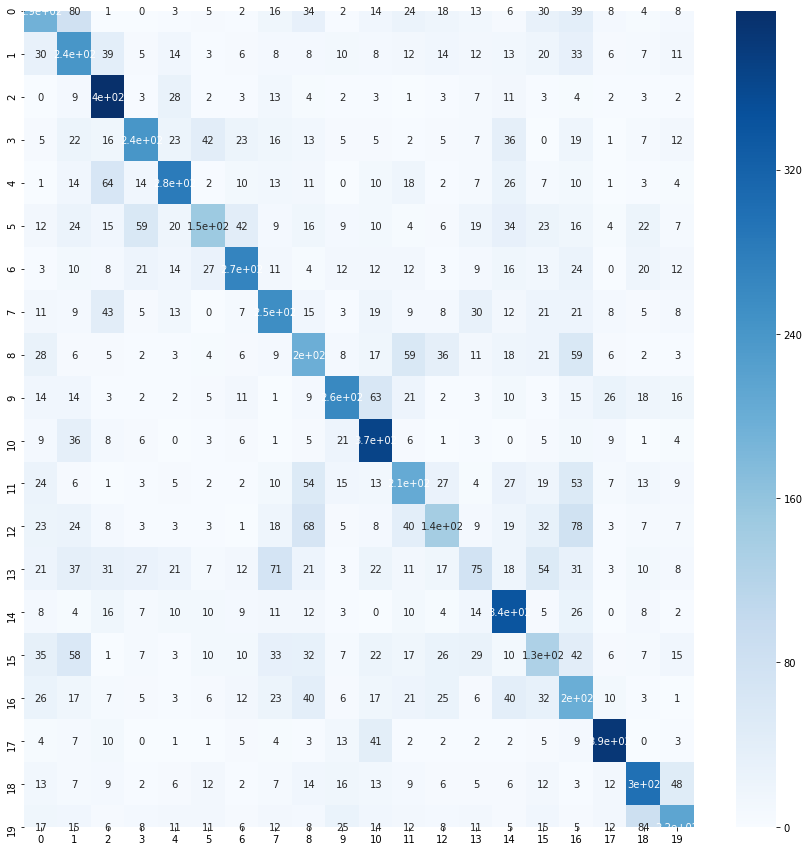

In [163]:
confusion_CNN_test = pd.DataFrame(CONFUSION_matrix(y_pred, FINAL_test_labels))
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(confusion_CNN_test, annot=True, cmap='Blues')

In [168]:
confusion_CNN_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,193,80,1,0,3,5,2,16,34,2,14,24,18,13,6,30,39,8,4,8
1,30,241,39,5,14,3,6,8,8,10,8,12,14,12,13,20,33,6,7,11
2,0,9,397,3,28,2,3,13,4,2,3,1,3,7,11,3,4,2,3,2
3,5,22,16,241,23,42,23,16,13,5,5,2,5,7,36,0,19,1,7,12
4,1,14,64,14,283,2,10,13,11,0,10,18,2,7,26,7,10,1,3,4
5,12,24,15,59,20,149,42,9,16,9,10,4,6,19,34,23,16,4,22,7
6,3,10,8,21,14,27,269,11,4,12,12,12,3,9,16,13,24,0,20,12
7,11,9,43,5,13,0,7,253,15,3,19,9,8,30,12,21,21,8,5,8
8,28,6,5,2,3,4,6,9,197,8,17,59,36,11,18,21,59,6,2,3
9,14,14,3,2,2,5,11,1,9,262,63,21,2,3,10,3,15,26,18,16
